<a href="https://colab.research.google.com/github/seoharu/DATA-AI/blob/main/face_mask_detection_faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np               # linear algebra
import pandas as pd              # data processing, CSV file I/O
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

import os

In [2]:
def generate_box(obj):

  xmin = int(obj.find('xmin').text)
  ymin = int(obj.find('ymin').text)
  xmax = int(obj.find('xmax').text)
  ymax = int(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]

def generate_label(obj):
  if obj.find('name').text == "with_mask":
    return 1
  elif obj.find('name').text == "mask_weared_incorrect":
    return 2
  return 0

def generate_target(image_id, file):
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')

    num_objs = len(objects)

    boxes = []
    labels = []

    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))
    boxes = torch.as_tensor(boxes, dtype = torch.float32)

    labels = torch.as_tensor(labels, dtype=torch.int64)

    img_id = torch.tensor([image_id])

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = img_id

    return target

In [3]:
imgs = list(sorted(os.listdir("/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/images")))


In [4]:
labels = list(sorted(os.listdir("/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/annotations")))

In [5]:
class MaskDataset(object):
  def __init__(self, transforms):
    self.transforms = transforms

    self.imgs = list(sorted(os.listdir("/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/images")))

  def __getitem__(self, idx):
    file_image = 'maksssksksss' + str(idx) + '.png'
    file_label = 'maksssksksss' + str(idx) + '.xml'
    img_path = os.path.join("/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/images", file_image)
    label_path = os.path.join("/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/archive/annotations", file_label)
    img = Image.open(img_path).convert("RGB")

# generate label
    target = generate_target(idx, label_path)

    if self.transforms is not None:
      img = self.transforms(img)

    return img, target

  def __len__(self):
    return len(self.imgs)


In [6]:
data_transform = transforms.Compose([transforms.ToTensor(), ])

In [7]:
def collate_fn(batch):
  return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, collate_fn = collate_fn
)

In [8]:
torch.cuda.is_available()

True

In [9]:
# Model

def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [10]:
model = get_model_instance_segmentation(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 98.7MB/s]


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  print(annotations)
  break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

In [ ]:
# Train Model

num_epochs = 25
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
  model.train()
  i = 0
  epoch_loss = 0
  for imgs, annotations in data_loader:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model([imgs[0]], [annotations[0]])
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    epoch_loss += losses
  print(epoch_loss)


tensor(86.4596, device='cuda:0', grad_fn=<AddBackward0>)
tensor(59.3774, device='cuda:0', grad_fn=<AddBackward0>)
tensor(48.5168, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.5111, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.7056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.9489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.2434, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.4644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.5857, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.1776, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.9044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.9270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.7996, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.0767, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.4740, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.4823, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.2155, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.3775, device='cuda:0'

In [15]:
for imgs, annotations in data_loader:
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  break

In [ ]:
model.eval()
preds = model(imgs)
preds


In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

# function to plot image
def plot_image(img_tensor, annotation):
    fig, ax = plt.subplots(1)

    # Use detach() to remove gradient information before converting to NumPy array
    img = img_tensor.cpu().detach().numpy()

    # Display the image
    ax.imshow(img.transpose(1, 2, 0))

    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1, edgecolor='r', facecolor='none')

        # add the patch to the axes
        ax.add_patch(rect)

    plt.show()

Prediction


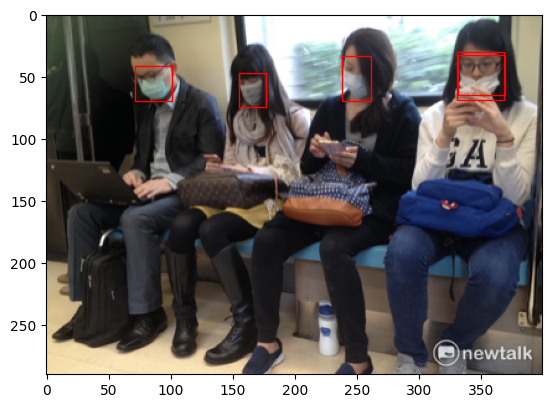

Target


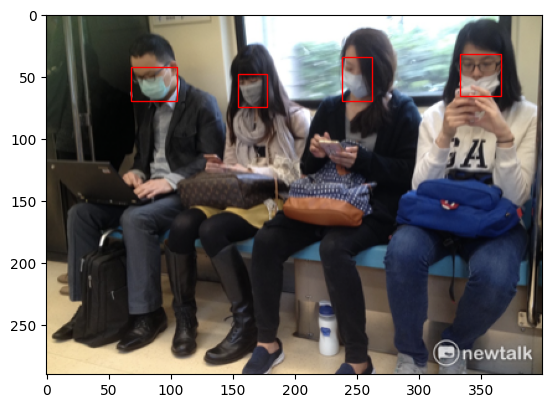

In [40]:
# Move both image and prediction tensors to CPU before calling plot_image
print("Prediction")

# Extract the "boxes" tensor from the preds[2] dictionary and move it to CPU
preds_boxes_cpu = {"boxes": preds[2]["boxes"].cpu().detach()}

# Use detach() to remove gradient information before calling numpy()
plot_image(imgs[2].cpu(), preds_boxes_cpu)
print("Target")

# Extract the "boxes" tensor from the annotations[2] dictionary and move it to CPU
annotations_boxes_cpu = {"boxes": annotations[2]["boxes"].cpu().detach()}

# Use detach() to remove gradient information before calling numpy()
plot_image(imgs[2].cpu(), annotations_boxes_cpu)

In [41]:
torch.save(model.state_dict(), 'model.pt')

In [42]:
model2 = get_model_instance_segmentation(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
# Save Model

model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [47]:
# Load Model

with torch.no_grad():
    pred2 = model2(imgs)


Predict with loaded model for image 0


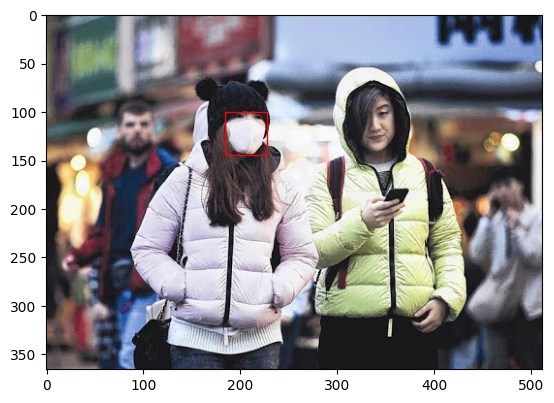

Predict with loaded model for image 1


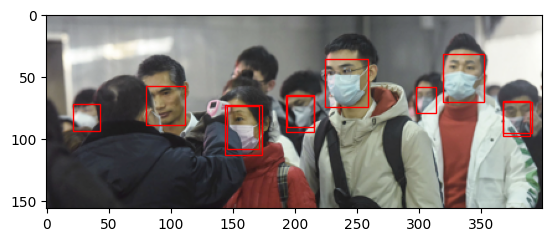

Predict with loaded model for image 2


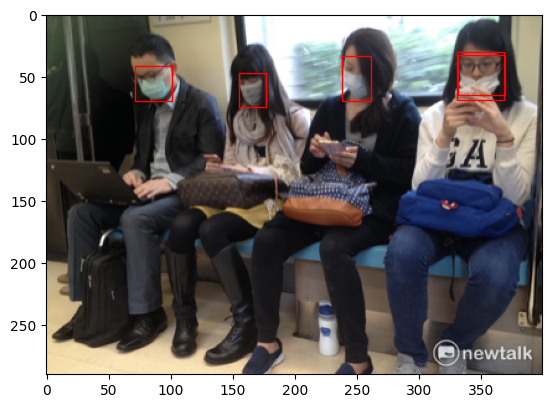

Predict with loaded model for image 3


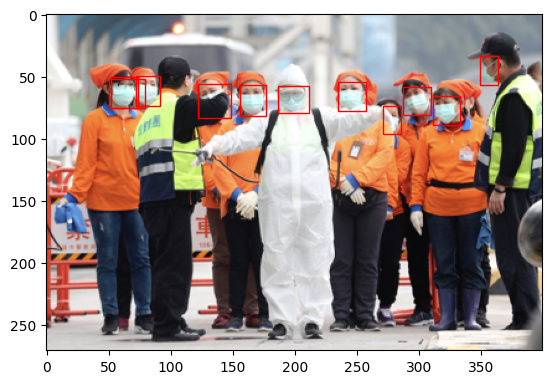

In [48]:
# print("Predict with loaded model")
# plot_image(imgs[3], pred2[3])
# Move both image and prediction tensors to CPU before calling plot_image
for i in range(len(imgs)):
    print(f"Predict with loaded model for image {i}")

    # Extract the "boxes" tensor from the pred2 dictionary and move it to CPU
    pred2_boxes_cpu = {"boxes": pred2[i]["boxes"].cpu().detach()}

    # Move the input image tensor to CPU before plotting
    img_cpu = imgs[i].cpu()

    # Use detach() to remove gradient information before calling numpy()
    plot_image(img_cpu, pred2_boxes_cpu)